# Part 1: MLP Model for Prediction

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [4]:
# 1. Load your dataset
data = pd.read_csv("Datasets.csv")  # Replace with your actual file path

In [5]:
# 2. Separate features (X/params) and target (y/poisson)
params = data.iloc[:, :-1]
poisson = data.iloc[:,-1:]


In [6]:
# 3. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(params, poisson, test_size=0.2, random_state=42)

In [7]:
# 4. Scale the features and the target
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)


In [8]:
# 5. Create PyTorch Datasets
class ReentrantDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ReentrantDataset(X_train_scaled, y_train_scaled)
test_dataset = ReentrantDataset(X_test_scaled, y_test_scaled)


In [9]:
# 6. Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [8]:
# 7. Define the MLP Model
class PoissonPredictor(nn.Module):
    def __init__(self, input_size):
        super(PoissonPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()
        self.fc_out = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc_out(x)
        return x

input_size = X_train_scaled.shape[1]  # Number of features
model = PoissonPredictor(input_size)


In [18]:
# 8. Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


AttributeError: module 'sympy' has no attribute 'printing'

In [ ]:
# 9. Training Loop
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


In [ ]:
# 10. Evaluate the Model (Optional)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_pred = target_scaler.inverse_transform(outputs.cpu().numpy())
        y_true = target_scaler.inverse_transform(targets.cpu().numpy())
        y_pred_list.extend(y_pred)
        y_true_list.extend(y_true)

r2 = r2_score(y_true_list, y_pred_list)
mae = mean_absolute_error(y_true_list, y_pred_list)
rmse = mean_squared_error(y_true_list, y_pred_list, squared=False)

print(f'R-squared on Test Set: {r2:.4f}')
print(f'MAE on Test Set: {mae:.4f}')
print(f'RMSE on Test Set: {rmse:.4f}')

# Part 2: Symbolic Regression with PySR

In [1]:
import numpy
import sympy # NOTE sympy must be version 1.13.1
import pysr
from pysr import PySRRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [10]:
# 1. Load your dataset again
data_sr = pd.read_csv("Datasets.csv")

In [11]:
# 2. Separate features (X/params) and target (y/poisson)
params_sr = data_sr.iloc[:, :-1]
poisson_sr = data_sr.iloc[:,-1:]


In [12]:
# 3. Split data into training and testing sets (same split as before for comparison)
X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(params_sr, poisson_sr, test_size=0.2, random_state=42)


In [21]:
# 4. Initialize and run PySR
model_sr = PySRRegressor(
    # n_features=X_train_sr.shape[1], # NOTE might not be necessary since we're making a first pass of training on all features. revisit later to do term reduction
    # feature_names=['slant_length', 'thickness', 'angle', 'vertical_length'],
    populations=5,
    population_size=100,      # number of individuals per population
    # loss='mse', # NOTE can't specify a loss function as a string, needs to be custom julia code
    niterations=80,
    # You can specify the mathematical operations to use
    # default_operations=['+', '-', '*', '/'],
    # extra_sympy_mappings={'sin': 'sin', 'cos': 'cos'}, # Example for trigonometric functions
    # unary_operators=[np.exp, np.log, 'abs', 'sin', 'cos'], # Example for unary operators
    # binary_operators=['+', '-', '*', '/'],
    # complexity_of_operators={'*': 1, '/': 2, '+': 1, '-': 1, 'exp': 3, 'log': 3, 'sin': 2, 'cos': 2, 'abs': 1},
    random_state=42,
    procs=6,                 # Number of CPU cores to use (may 3: 4 cores, may 7: 6 cores), 
    deterministic=True,
    parallelism ='serial',
)

print("\nStarting Symbolic Regression...")
model_sr.fit(X_train_sr, y_train_sr, variable_names=['slant_length', 'thickness', 'angle', 'vertical_length'])

In [14]:
model_sr.sympy()

(Cell_angle - Slant_cell_length)*(Cell_angle*(-1.9645575e-5 + 0.0016910352/Cell_angle)*Slant_cell_length*Slant_cell_length*(-2.7323828) + 0.064948626)/Vertical_cell_length

In [17]:
# TODO write a function that automatically parses model output into an equation that can be fed the points of a dataset.
print(model_sr.pytorch())

equations = list(model_sr.equations_['equation'])
print(equations)


_SingleSymPyModule(expression=(Cell_angle - Slant_cell_length)*(Cell_angle*(-1.9645575e-5 + 0.0016910352/Cell_angle)*Slant_cell_length*Slant_cell_length*(-2.7323828) + 0.064948626)/Vertical_cell_length)
['-0.057378877', 'Slant_cell_length * -0.0070060696', '(Slant_cell_length * -0.01749015) - -0.14429756', '(Slant_cell_length + -7.9955964) * (-0.9211532 / Cell_angle)', '((Cell_angle * 0.00086687214) - (Slant_cell_length * 0.0063558617)) / 0.36121404', '(((Cell_angle * Cell_angle) * ((-0.0020788074 / Cell_angle) + 1.9434918e-5)) + 0.041405607) * Slant_cell_length', '((((0.00039431467 / Cell_angle) - 4.168352e-6) * ((Cell_angle * Slant_cell_length) * -2.6812778)) * Cell_angle) + 0.1677473', '(((0.00030651086 / Cell_angle) + -3.2427429e-6) * (((Cell_angle - 1.4157107) * (Slant_cell_length * -3.4559855)) * Cell_angle)) + 0.16639291', '(((0.00030651086 / Cell_angle) + -3.2427429e-6) * ((Cell_angle - 1.4157107) * (Slant_cell_length * (-3.4559855 * (0.04325803 + Cell_angle))))) + 0.16639291',

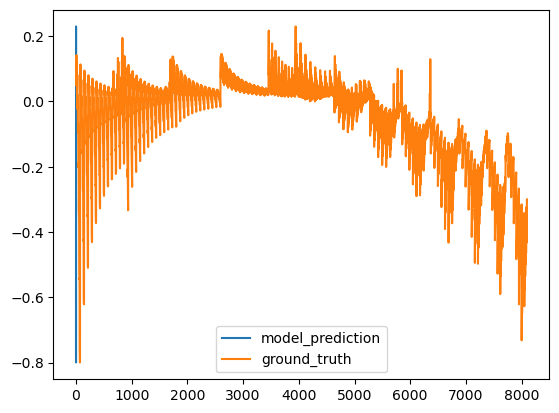

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared on Test Set: 0.8261
MAE on Test Set: 0.0415
RMSE on Test Set: 0.0558


In [18]:
# print(data.columns)

def validate_run(dataset, equation=None):
    """
    take in the raw set of geometry<->poisson ratio mappings
    and return a plot of SR model predictions.
    """
    slant_cell_length = numpy.asarray(dataset['Slant cell length'])
    cell_thickness = numpy.asarray(dataset['Cell thickness'])
    cell_angle = numpy.asarray(dataset['Cell angle'])
    vertical_cell_length = numpy.asarray(dataset['Vertical cell length'])
    poisson_ratio = numpy.asarray(dataset['Poisson\'s ratio'])

    model_predictions = []
    for idx in range(len(dataset)):
        model_predictions.append(equation(slant_cell_length=slant_cell_length[idx],cell_thickness=cell_thickness[idx],cell_angle=cell_angle[idx], vertical_cell_length=vertical_cell_length[idx]))
    
    plt.plot(model_predictions, poisson_ratio)
    plt.plot(poisson_ratio)
    plt.legend(['model_prediction','ground_truth'])
    plt.show()

    r2 = r2_score(poisson_ratio, model_predictions)
    mae = mean_absolute_error(poisson_ratio, model_predictions)
    rmse = mean_squared_error(poisson_ratio, model_predictions, squared=False)

    print(f'R-squared on Test Set: {r2:.4f}')
    print(f'MAE on Test Set: {mae:.4f}')
    print(f'RMSE on Test Set: {rmse:.4f}')
        

# TODO make automated function generation work with this below block of code. want to go from sympy --> actionable equation  
def run_1_SR(slant_cell_length, cell_thickness, cell_angle, vertical_cell_length): 
    '''
    Validate best equation of `outputs/20250503_224212_5kTnhb`
    Model hyperparams:
        populations=5,
        population_size=50,      # number of individuals per population
        niterations=100,
        random_state=42,
        procs=4,                 # Number of CPU cores to use (may 3: 4 cores, may 7: 6 cores), 
    '''
    poisson_prediction = (slant_cell_length*0.17546645*vertical_cell_length/(cell_angle + slant_cell_length*(vertical_cell_length/(cell_angle - slant_cell_length) - 3.8501096)) - 2.687245)*(-0.031911876)
    return poisson_prediction

def run_2_SR(slant_cell_length, cell_thickness, cell_angle, vertical_cell_length): 
    '''
    Validate best equation of 'outputs/20250507_203453_6Th53a'
    Model hyperparams:
        populations=5,
        population_size=100,      # number of individuals per population
        niterations=40,
        random_state=42,
        procs=6,                 # Number of CPU cores to use (may 3: 4 cores, may 7: 6 cores), 
        deterministic=True,
        parallelism ='serial'
    '''
    poisson_prediction = (cell_angle - slant_cell_length)*(cell_angle*(-1.9645575e-5 + 0.0016910352/cell_angle)*slant_cell_length*slant_cell_length*(-2.7323828) + 0.064948626)/vertical_cell_length
    return poisson_prediction

def run_2_SR(slant_cell_length, cell_thickness, cell_angle, vertical_cell_length): 
    '''
    Validate best equation of ''
    Model hyperparams:
        populations=5,
        population_size=100,      # number of individuals per population
        niterations=40,
        random_state=42,
        procs=6,                 # Number of CPU cores to use (may 3: 4 cores, may 7: 6 cores), 
        deterministic=True,
        parallelism ='serial'
    '''
    poisson_prediction = (cell_angle - slant_cell_length)*(cell_angle*(-1.9645575e-5 + 0.0016910352/cell_angle)*slant_cell_length*slant_cell_length*(-2.7323828) + 0.064948626)/vertical_cell_length
    return poisson_prediction

# validate_run(data, run_1_SR)
# validate_run(data, run_2_SR)
validate_run(data, run_2_SR)


    


In [ ]:
import matplotlib
from scipy.interpolate import griddata

# X-Y are transformed into 2D grids. It's like a form of interpolation
x1 = np.linspace(x.min(), x.max(), len(np.unique(x))); 
y1 = np.linspace(y.min(), y.max(), len(np.unique(y)));
x2, y2 = np.meshgrid(x1, y1);

# Interpolation of Z: old X-Y to the new X-Y grid.
# Note: Sometimes values ​​can be < z.min and so it may be better to set 
# the values too low to the true minimum value.
z2 = griddata( (x, y), z, (x2, y2), method='cubic', fill_value = 0);
z2[z2 < z.min()] = z.min();

# Interpolation of C: old X-Y on the new X-Y grid (as we did for Z)
# The only problem is the fact that the interpolation of C does not take
# into account Z and that, consequently, the representation is less 
# valid compared to the previous solutions.
c2 = griddata( (x, y), c, (x2, y2), method='cubic', fill_value = 0);
c2[c2 < c.min()] = c.min(); 

#--------
color_dimension = c2; # It must be in 2D - as for "X, Y, Z".
minn, maxx = color_dimension.min(), color_dimension.max();
norm = matplotlib.colors.Normalize(minn, maxx);
m = plt.cm.ScalarMappable(norm=norm, cmap = name_color_map);
m.set_array([]);
fcolors = m.to_rgba(color_dimension);

# At this time, X-Y-Z-C are all 2D and we can use "plot_surface".
fig = plt.figure(); ax = fig.gca(projection='3d');
surf = ax.plot_surface(x2, y2, z2, facecolors = fcolors, linewidth=0, rstride=1, cstride=1,
                       antialiased=False);
cbar = fig.colorbar(m, shrink=0.5, aspect=5);
cbar.ax.get_yaxis().labelpad = 15; cbar.ax.set_ylabel(list_name_variables[index_c], rotation = 270);
ax.set_xlabel(list_name_variables[index_x]); ax.set_ylabel(list_name_variables[index_y]);
ax.set_zlabel(list_name_variables[index_z]);
plt.title('%s in fcn of %s, %s and %s' % (list_name_variables[index_c], list_name_variables[index_x], list_name_variables[index_y], list_name_variables[index_z]) );
plt.show();